# Import Package and Functions

In [54]:
import jax
import jax.numpy  as jnp
from jax import lax
from jax import random
import numpy as np
import matplotlib.pyplot  as plt
import torch
import torchvision
import time
from torchvision import datasets, transforms
from jax.scipy.stats import mode
from sklearn.model_selection  import train_test_split

# Data Preprocess Functions

In [55]:
@jax.jit
def standardize_data(data):
    mean = jnp.mean(data, axis=0)
    std = jnp.std(data, axis=0)
    data_standardized = (data - mean) / (std + 1e-8)
    return data_standardized

In [56]:
@jax.jit
def normalize_to_0_1(data):
    data_min = jnp.min(data, axis=0)
    data_max = jnp.max(data, axis=0)
    data_normalized = (data - data_min) / (data_max - data_min + 1e-8)
    return data_normalized

In [57]:
@jax.jit
def normalize_to_neg1_1(data):
    data_min = jnp.min(data, axis=0)
    data_max = jnp.max(data, axis=0)
    data_normalized = (2 * data - (data_max + data_min)) / (data_max - data_min + 1e-8)
    return data_normalized

In [58]:
@jax.jit
def zca_whiten_data(data):
    mean = jnp.mean(data, axis=0)
    data_centered = data - mean
    cov = jnp.cov(data_centered, rowvar=False)
    eigvals, eigvecs = jnp.linalg.eigh(cov)
    epsilon = 1e-8
    zca_matrix = jnp.dot(eigvecs, jnp.dot(jnp.diag(1.0 / jnp.sqrt(eigvals + epsilon)), eigvecs.T))
    data_zca_whitened = jnp.dot(data_centered, zca_matrix)
    return data_zca_whitened


# Download CIFAR-10 Dataset
## Split train dataset to train dataset and validate dataset

In [107]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_data = np.array(train_dataset.data)
train_labels = np.array(train_dataset.targets)
train_data = train_data.transpose(0, 3, 1, 2)

X_train, X_val, y_train, y_val = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)

X_test = np.array(test_dataset.data).transpose(0,  3, 1, 2)
y_test = np.array(test_dataset.targets)

X_train_jax = jnp.array(X_train  / 255.0)
X_val_jax = jnp.array(X_val  / 255.0)
X_test_jax = jnp.array(X_test  / 255.0)

y_train_jax = jnp.array(y_train)
y_val_jax = jnp.array(y_val)
y_test_jax = jnp.array(y_test)

X_train_jax = X_train_jax.reshape((X_train_jax.shape[0], -1))
# X_train_jax = standardize_data(X_train_jax)
# X_train_jax = normalize_to_0_1(X_train_jax)
# X_train_jax = normalize_to_neg1_1(X_train_jax)
# X_train_jax = pca_data(X_train_jax)
X_train_jax = zca_whiten_data(X_train_jax)
X_val_jax = X_val_jax.reshape((X_val_jax.shape[0], -1))
# X_val_jax = standardize_data(X_val_jax)
# X_val_jax = normalize_to_0_1(X_val_jax)
# X_val_jax = normalize_to_neg1_1(X_val_jax)
# X_val_jax = pca_data(X_val_jax)
X_val_jax = zca_whiten_data(X_val_jax)
X_test_jax = X_test_jax.reshape((X_test_jax.shape[0], -1))
# X_test_jax = standardize_data(X_test_jax)
# X_test_jax = normalize_to_0_1(X_test_jax)
# X_test_jax = normalize_to_neg1_1(X_test_jax)
# X_test_jax = pca_data(X_test_jax)
X_test_jax = zca_whiten_data(X_test_jax)


In [108]:
@jax.jit
def compute_l2_distances(X_test, X_train):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    distances = jnp.zeros((num_test, num_train))
    X_test_squared = jnp.sum(X_test ** 2, axis=1, keepdims=True)
    X_train_squared = jnp.sum(X_train ** 2, axis=1, keepdims=True)
    inner_prod = jnp.dot(X_test, X_train.T)
    distances = jnp.sqrt(X_test_squared - 2 * inner_prod + X_train_squared.T)
    return distances

@jax.jit
def compute_l1_distances(X_test, X_train):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    distances = jnp.zeros((num_test, num_train))
    distances = jnp.sum(jnp.abs(X_test[:, jnp.newaxis] - X_train), axis=2)
    return distances

@jax.jit
def compute_cosine_distances(X_test, X_train):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    distances = jnp.zeros((num_test, num_train))
    dot_product = jnp.dot(X_test, X_train.T)
    test_norm = jnp.linalg.norm(X_test, axis=1, keepdims=True)
    train_norm = jnp.linalg.norm(X_train, axis=1, keepdims=True)
    cosine_similarity = dot_product / (test_norm * train_norm.T + 1e-8)
    distances = 1 - cosine_similarity
    return distances

@jax.jit
def compute_chebyshev_distances(X_test, X_train):
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    distances = jnp.zeros((num_test, num_train))
    distances = jnp.max(jnp.abs(X_test[:, jnp.newaxis] - X_train), axis=2)
    return distances

@jax.jit
def k_nearest_neighbors(distances, k=1):
    sorted_indices = jnp.argsort(distances,  axis=1)
    def slice_row(row):
        return lax.dynamic_slice(row,  (0,), (k,))
    indices = jnp.apply_along_axis(slice_row,  1, sorted_indices)
    return indices


@jax.jit
def get_neighbor_labels(indices, y_train):
  neighbor_labels = y_train[indices]
  return neighbor_labels

@jax.jit
def majorith_voting(neighbor_labels):
  mode_results = mode(neighbor_labels, axis=1)
  predictions = mode_results.mode.reshape(-1)
  return predictions

@jax.jit
def predict(X_test, X_train_jax, y_train_jax):
  dist = compute_cosine_distances(X_test, X_train_jax)
  indices = k_nearest_neighbors(dist)
  neighbor_labels = get_neighbor_labels(indices, y_train_jax)
  predictions = majorith_voting(neighbor_labels)
  return predictions

Test Accuracy: 0.3758
Test time: 1.3294119834899902


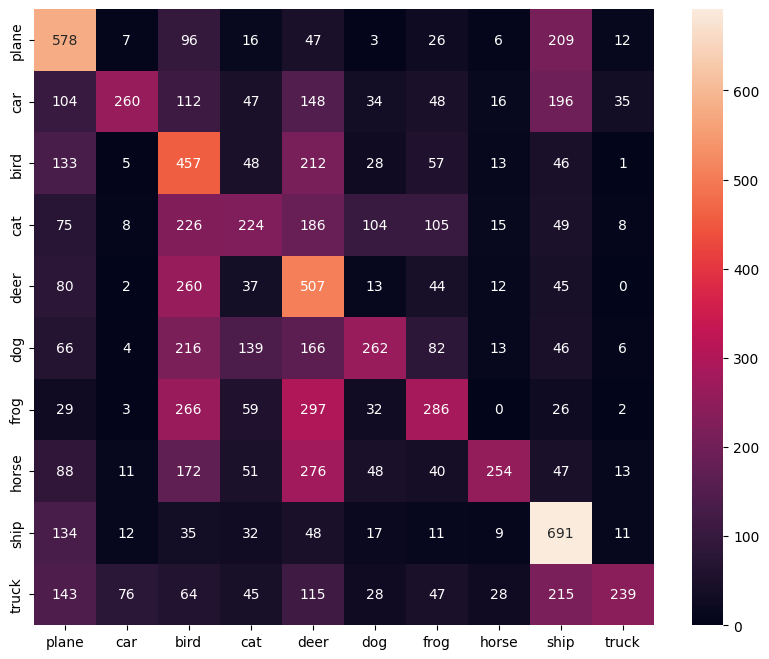

In [75]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
start = time.time()
predicted_labels_test = predict(X_test_jax, jnp.vstack([X_train_jax, X_val_jax]), jnp.concatenate([y_train_jax, y_val_jax]))
acc_test = jnp.mean(predicted_labels_test == y_test_jax)
end = time.time()
print(f"Test Accuracy: {acc_test:.4f}")
print("Test time:", end - start)
cm_knn = confusion_matrix(y_test_jax, predicted_labels_test)

class_names = train_dataset.classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,8))
sns.heatmap(cm_knn, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
# plt.title('KNN Confusion Matrix')
plt.savefig('confusion_matrix_knn.pdf', dpi=300, bbox_inches='tight')  # 保存高清图片
plt.show()

In [109]:
predicted_labels_val = predict(X_val_jax, X_train_jax, y_train_jax)
acc_val = jnp.mean(predicted_labels_val == y_val_jax)
print(f"Validation Accuracy: {acc_val:.4f}")

start = time.time()
predicted_labels_test = predict(X_test_jax, jnp.vstack([X_train_jax, X_val_jax]), jnp.concatenate([y_train_jax, y_val_jax]))
end = time.time()
acc_test = jnp.mean(predicted_labels_test == y_test_jax)
print(f"Test Accuracy: {acc_test:.4f} and Time:{end-start}")

Validation Accuracy: 0.0996
Test Accuracy: 0.2279 and Time:1.151066541671753


|# DataSet Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

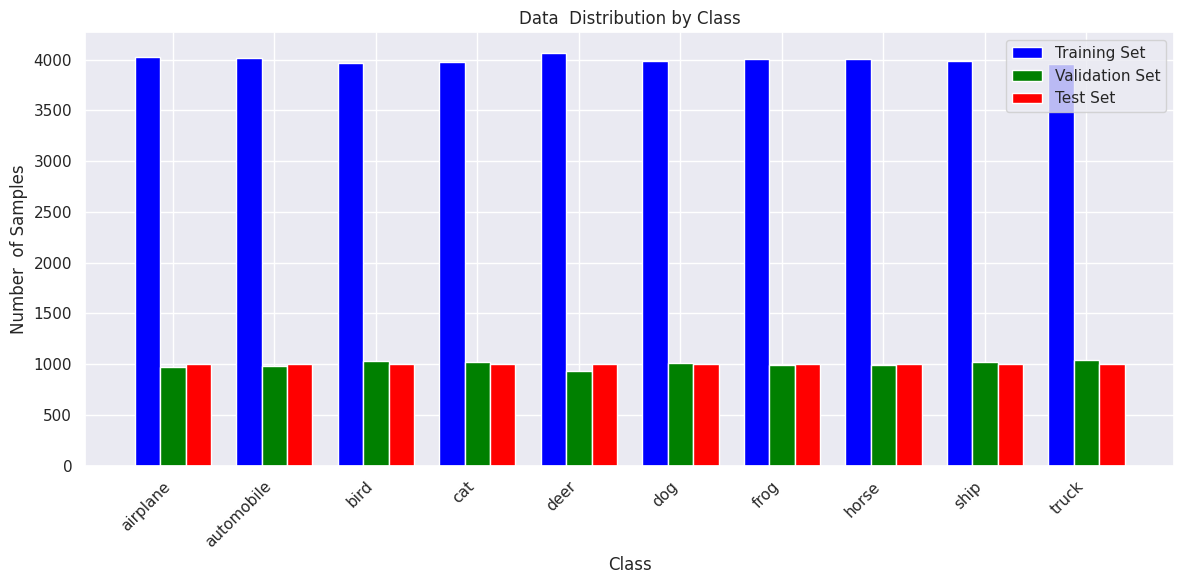

In [ ]:
import matplotlib.pyplot  as plt
import numpy as np
import seaborn as sns
from google.colab import files

sns.set()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def count_samples(labels):
    counts = np.bincount(labels)
    return counts

train_counts = count_samples(y_train)
val_counts = count_samples(y_val)
test_counts = count_samples(y_test)

plt.figure(figsize=(12,  6))

bar_width = 0.25
index = np.arange(len(class_names))

plt.bar(index,  train_counts, bar_width, label='Training Set', color='blue')

plt.bar(index  + bar_width, val_counts, bar_width, label='Validation Set', color='green')

plt.bar(index  + 2*bar_width, test_counts, bar_width, label='Test Set', color='red')

plt.title('Data  Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number  of Samples')

plt.xticks(index  + bar_width, class_names, rotation=45, ha='right')

plt.legend()

plt.tight_layout()

# plt.show()

plt.savefig("dataset.pdf", dpi=300)
files.download('dataset.pdf')
plt.show()


# Random Image Visualization

Files already downloaded and verified
Files already downloaded and verified


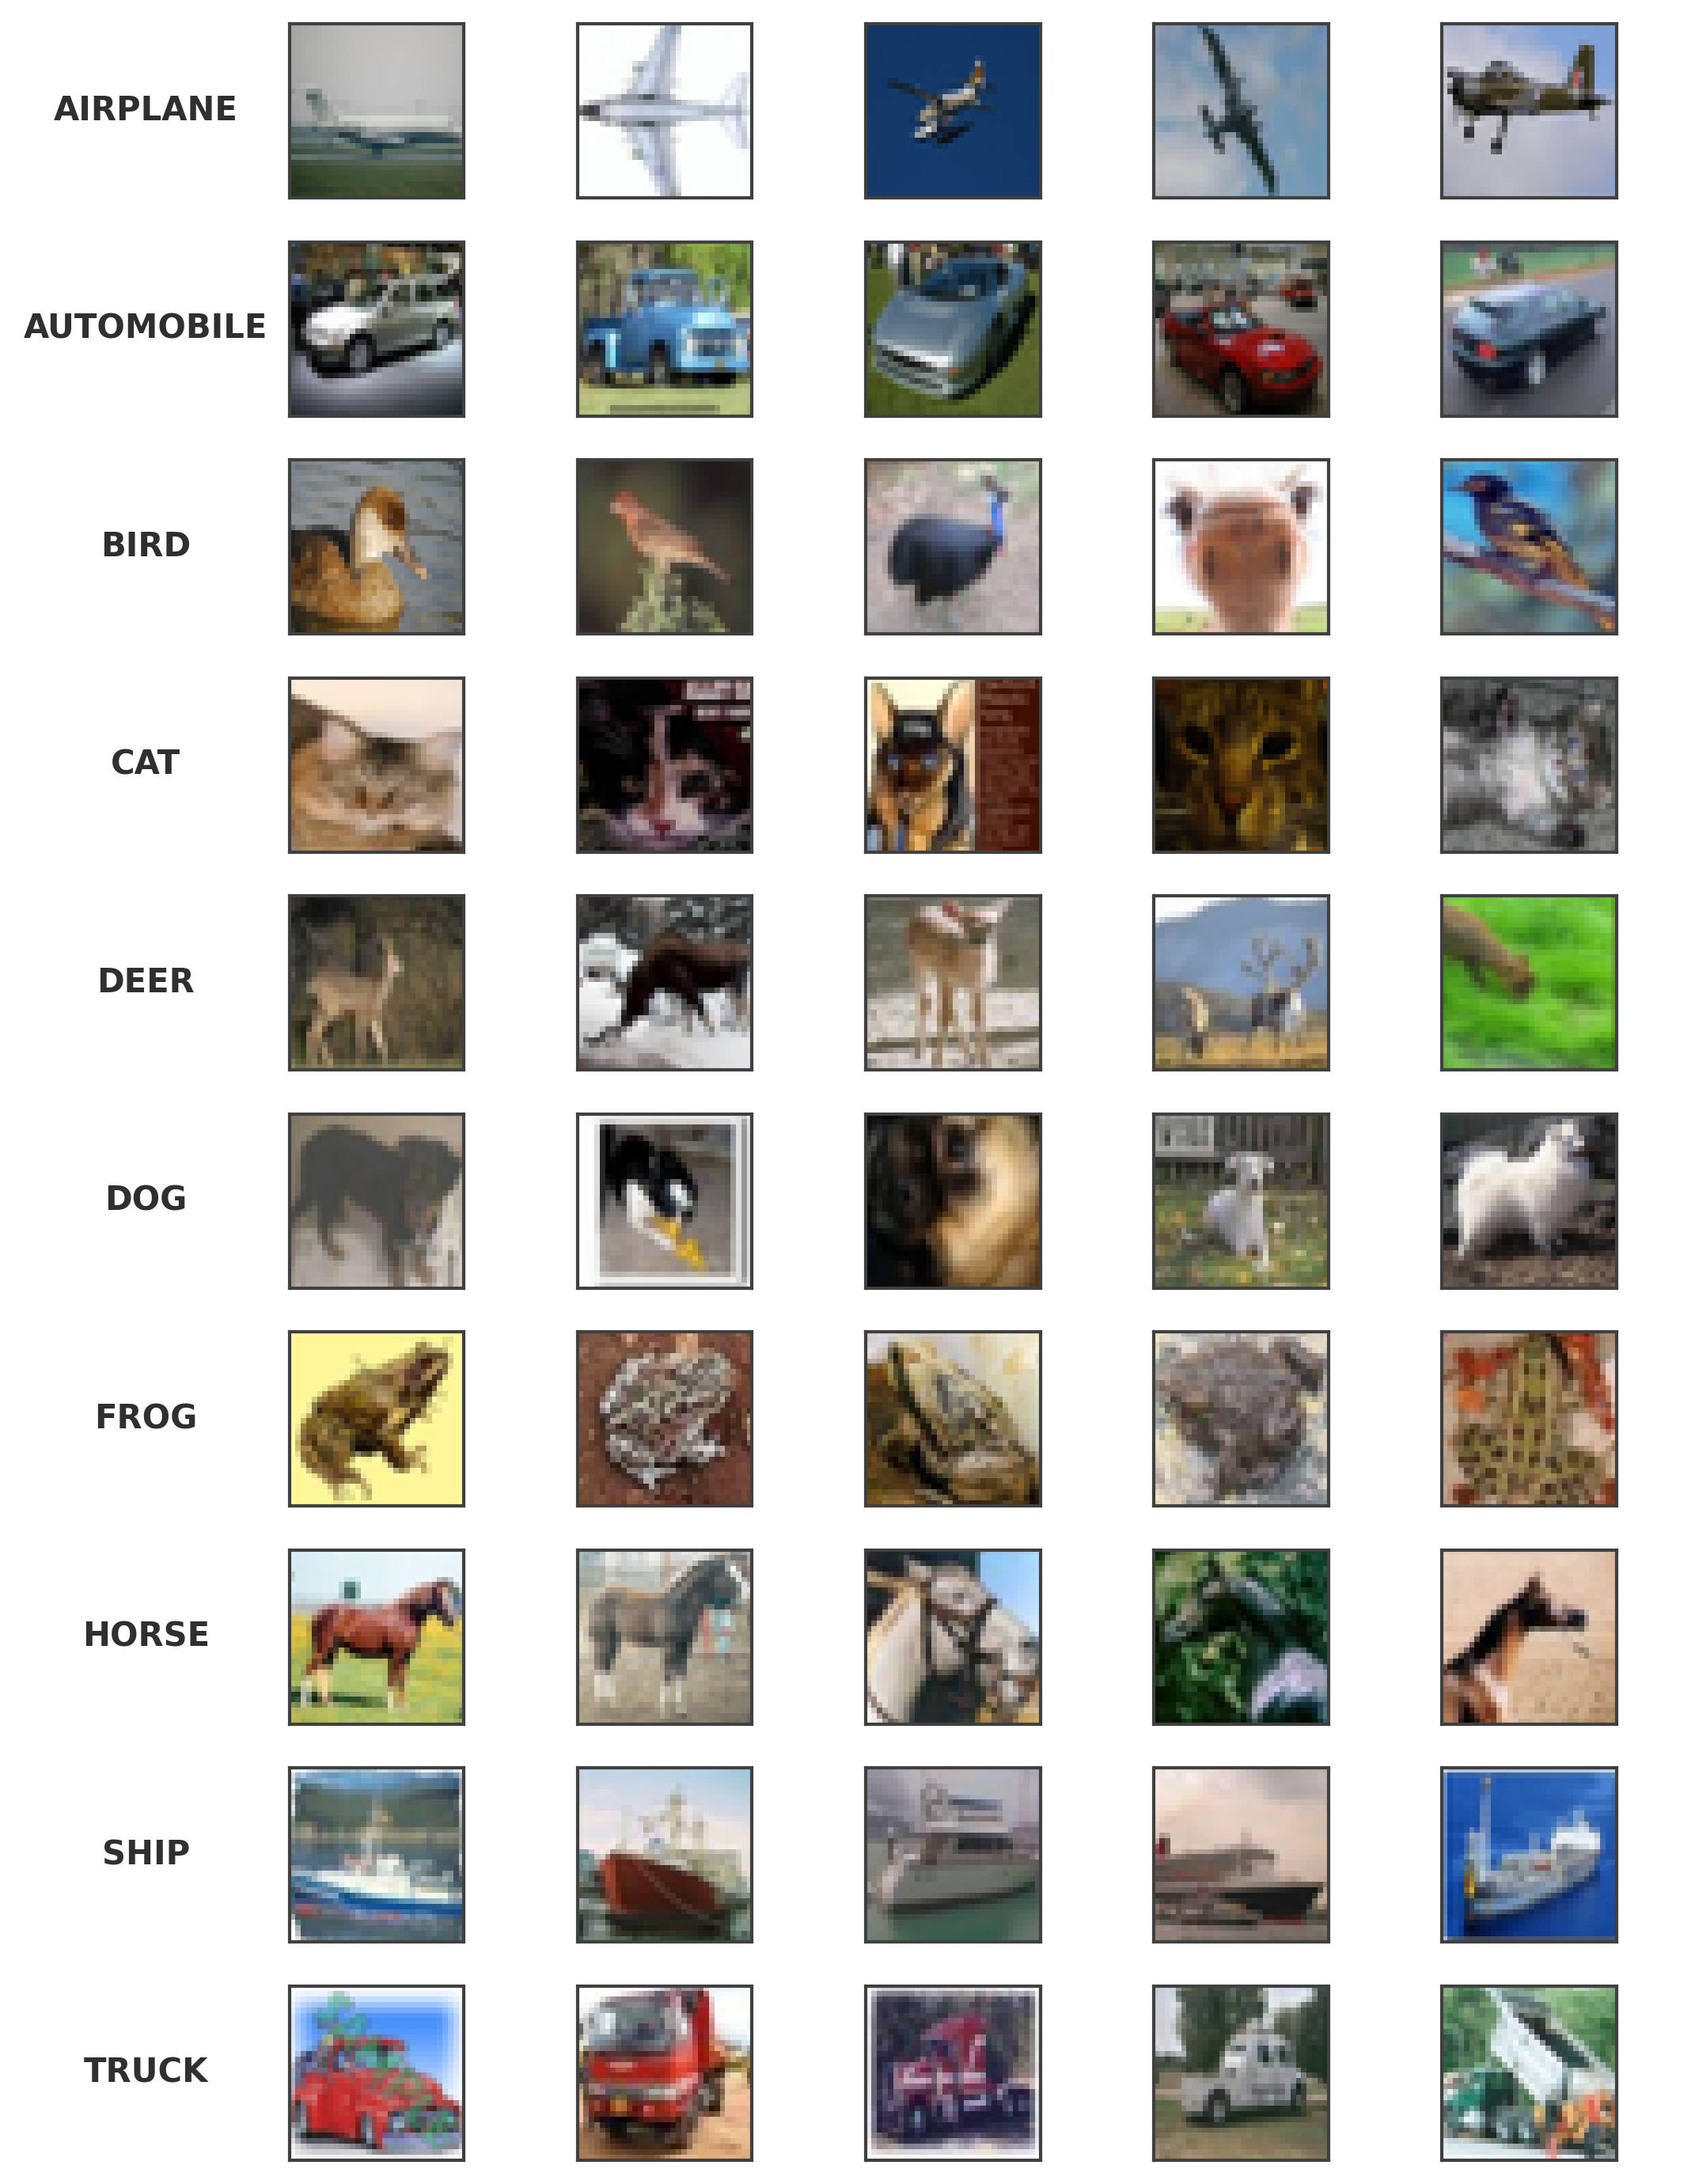

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load raw data without normalization for visualization
trainset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset_raw = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# Convert to numpy arrays and normalize
X_train = trainset_raw.data.astype('float32') / 255.0
y_train = np.array(trainset_raw.targets)
X_test = testset_raw.data.astype('float32') / 255.0
y_test = np.array(testset_raw.targets)

# Split training into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(7, 10), dpi=300)  # 高分辨率画布
n_samples = 5  # 每类样本数
class_names = trainset_raw.classes
border_color = '#404040'  # 边框颜色
bg_color = '#f0f0f0'     # 背景颜色

# 创建网格布局
gs = plt.GridSpec(len(class_names), n_samples+1,
                width_ratios=[0.6]+[1]*n_samples,  # 减少标签列宽度
                wspace=0.01,  # 列间距从0.05改为0.01
                hspace=0.25)  # 保持行间距

# 设置全局背景
plt.gca().set_facecolor(bg_color)
plt.gca().set_axis_off()

for class_idx in range(len(class_names)):
    # 添加类别标签
    label_ax = plt.subplot(gs[class_idx, 0])
    label_ax.text(0.5, 0.5, class_names[class_idx].upper(),
                 fontsize=10, weight='bold',
                 ha='center', va='center',
                 color='#2f2f2f', rotation=0)
    label_ax.set_facecolor(bg_color)
    label_ax.set_axis_off()

    # 绘制样本图像
    class_indices = np.where(y_train == class_idx)[0]
    selected_indices = np.random.choice(class_indices, n_samples, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = plt.subplot(gs[class_idx, i+1])
        ax.imshow(X_train[idx])

        # 美化设置
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_color(border_color)
        ax.spines['top'].set_color(border_color)
        ax.spines['right'].set_color(border_color)
        ax.spines['left'].set_color(border_color)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['top'].set_linewidth(1)
        ax.spines['right'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)


# plt.tight_layout()

plt.subplots_adjust(left=0.015, right=0.985,  # 增大画布利用率
                   top=0.95, bottom=0.05,
                   wspace=0.01)  # 额外添加间距控制
plt.savefig('enhanced_cifar10_grid.pdf', dpi=300, bbox_inches='tight')  # 保存高清图片
plt.show()